In [397]:
import numpy as np
import pandas as pd

from fastparquet import ParquetFile,write
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from cm2df import cm2df,precision_recall_fscore_support_metrics2df
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_fscore_support

In [398]:
pf=ParquetFile('subset_feature_4ML_110619.parq')
udf=pf.to_pandas()

In [399]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32880 entries, 11049447 to 9968570
Data columns (total 35 columns):
category                 32880 non-null int64
past                     32880 non-null int32
votes                    32880 non-null int64
is_eventbrite            32880 non-null int32
is_free                  32880 non-null int32
doors                    32880 non-null int32
sold_out                 32880 non-null int32
venue.id                 32880 non-null int64
venue.popularity         32880 non-null float64
venue.zip                32880 non-null int64
ticket_allages           32880 non-null int32
ticket_price_low         32880 non-null float64
ticket_price_max         32880 non-null float64
min_age                  32880 non-null int32
artist.popularity.sum    32880 non-null float64
artist.popularity.avg    32880 non-null float64
artist.popularity.max    32880 non-null float64
dow                      32880 non-null int64
doy                      32880 non-null in

In [400]:
udf['multiday'] = udf['multiday'].astype(int)

In [401]:
usecolsX=['category', 'past', 'is_eventbrite', 'is_free', 'doors',
       'sold_out', 'venue.id', 'venue.popularity', 'venue.zip',
       'ticket_allages', 'ticket_price_low', 'ticket_price_max', 'min_age',
       'artist.popularity.sum', 'artist.popularity.avg',
       'artist.popularity.max', 'dow', 'doy', 'month', 'day', 'hour',
       'venue.tol_num_events', 'duration', 'duration_day', 'multiday']
usecoly1=['votes']
usecoly2=['avg_votes_pday']

In [402]:
udf_X=udf[usecolsX]
udf_y=udf[usecoly1]

In [403]:
# scaling of the features
from sklearn.preprocessing import MinMaxScaler
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(udf_X)
X = scalar.transform(udf_X)

In [404]:
# a function to create udf_y based on 3 classes: low, mid, high
def get_class(df,thre1,thre2):
    n=len(df)
    newdf=[]
    cut1=min([thre1,thre2])
    cut2=max([thre1,thre2])
    for item in df:
        if item<cut1: newdf+=[0]
        elif (item<cut2) and (item>=cut1):newdf+=[1]
        else: newdf+=[2]
    return newdf

In [405]:
y=get_class(udf_y.values,80,300)

In [406]:
# import algorithms for model comparisons
# tree models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# setup the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12)

## Benchmark Model: Random Forest> 

In [420]:
prec_rec=[]
recal_rec=[]

In [421]:
max_f=int(25*0.75)

In [422]:
classifier=RandomForestClassifier(n_estimators=90,random_state=12,max_features=max_f,verbose=0)
classifier.fit(X_train,y_train)
pred_y_test=classifier.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)


0.47275094886601304


In [423]:
pred_y_train=classifier.predict(X_train)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(y_train, pred_y_train))
print("other metrics:",classification_report(y_train, pred_y_train))

confusion matrix: [[22127     1     0]
 [    1   740     0]
 [    0     0   147]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00       741
           2       1.00      1.00      1.00       147

    accuracy                           1.00     23016
   macro avg       1.00      1.00      1.00     23016
weighted avg       1.00      1.00      1.00     23016



In [424]:
# print confusion matrix
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9435   43    5]
 [ 209  105    4]
 [  35   14   14]]
other metrics:               precision    recall  f1-score   support

           0       0.97      0.99      0.98      9483
           1       0.65      0.33      0.44       318
           2       0.61      0.22      0.33        63

    accuracy                           0.97      9864
   macro avg       0.74      0.52      0.58      9864
weighted avg       0.96      0.97      0.96      9864



category 0.043974431271825834
past 0.0022794408428799796
is_eventbrite 0.006471281681909408
is_free 0.012343667901605302
doors 0.030375055305865043
sold_out 0.008169371091329812
venue.id 0.05841694032676937
venue.popularity 0.03127518002541883
venue.zip 0.038400818429050826
ticket_allages 0.0145533114779019
ticket_price_low 0.04075507012809534
ticket_price_max 0.02948631231804769
min_age 0.016907509752761007
artist.popularity.sum 0.18629980637147725
artist.popularity.avg 0.06065878311299467
artist.popularity.max 0.05568466235443122
dow 0.04135081275405356
doy 0.08185318826958878
month 0.029048741700711853
day 0.06488327738228888
hour 0.036214282014649546
venue.tol_num_events 0.04867079104264979
duration 0.05957713879115411
duration_day 0.0017229643866690353
multiday 0.000627161265870886


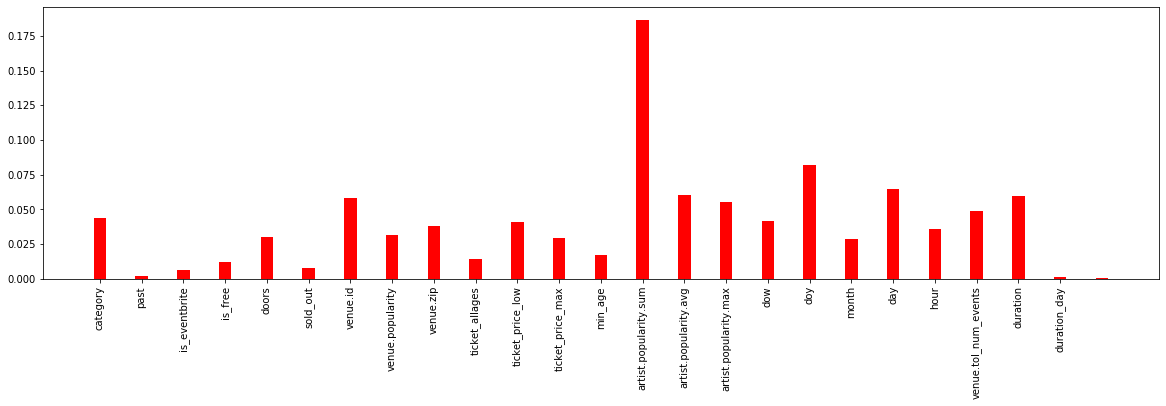

In [425]:
# list the feature importance
f_importance = pd.DataFrame({'feature':udf_X.columns, 'importance':classifier.feature_importances_})
#plot histogram
lenc = len(udf_X.columns)
x_tick_label=[None]*lenc
hist_val=np.zeros(lenc)
for i in range(0,lenc):
    hist_val[i] = f_importance.values[i][1]
    x_tick_label[i] = f_importance.values[i][0]
    print(x_tick_label[i],hist_val[i])
    
index = np.arange(lenc)+1
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(index,hist_val, .3, color='r')
ax.set_xticks(range(1, lenc, 1))
ax.set_xticklabels(x_tick_label, rotation='vertical')
plt.show()

In [426]:
# take a subset of the features, use those with importance > 0.025
mask= classifier.feature_importances_>=0.025

In [430]:
f_labels=udf_X.columns.values[mask]
f_imp=classifier.feature_importances_[mask]
f_importance = pd.DataFrame({'feature':f_labels, 'importance':f_imp})
for i in range(0,len(f_importance)):
    print(f_labels[i],f_imp[i])

category 0.043974431271825834
doors 0.030375055305865043
venue.id 0.05841694032676937
venue.popularity 0.03127518002541883
venue.zip 0.038400818429050826
ticket_price_low 0.04075507012809534
ticket_price_max 0.02948631231804769
artist.popularity.sum 0.18629980637147725
artist.popularity.avg 0.06065878311299467
artist.popularity.max 0.05568466235443122
dow 0.04135081275405356
doy 0.08185318826958878
month 0.029048741700711853
day 0.06488327738228888
hour 0.036214282014649546
venue.tol_num_events 0.04867079104264979
duration 0.05957713879115411


In [431]:
print("total number of subset features:",len(f_importance))

total number of subset features: 17


### subset data into these fewer features : 17 features

In [444]:
udf_X=udf_X[list(f_labels)]

In [445]:
scalar = MinMaxScaler()
scalar.fit(udf_X)
X = scalar.transform(udf_X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12)

In [446]:
max_f=len(udf_X.columns)

In [447]:
classifier2=RandomForestClassifier(n_estimators=90,random_state=12,max_features=max_f,verbose=0)
classifier2.fit(X_train,y_train)
pred_y_test=classifier2.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)


0.4227922976145222


In [451]:
pred_y_train=classifier2.predict(X_train)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(y_train, pred_y_train))
print("other metrics:",classification_report(y_train, pred_y_train))

confusion matrix: [[22127     1     0]
 [    1   740     0]
 [    0     0   147]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00       741
           2       1.00      1.00      1.00       147

    accuracy                           1.00     23016
   macro avg       1.00      1.00      1.00     23016
weighted avg       1.00      1.00      1.00     23016



In [452]:
# print confusion matrix
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9434   45    4]
 [ 217   97    4]
 [  35   18   10]]
other metrics:               precision    recall  f1-score   support

           0       0.97      0.99      0.98      9483
           1       0.61      0.31      0.41       318
           2       0.56      0.16      0.25        63

    accuracy                           0.97      9864
   macro avg       0.71      0.49      0.55      9864
weighted avg       0.96      0.97      0.96      9864



In [ ]:
print(sorted(sklearn.metrics.scorers.keys()))